# Import crucial packages

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd, YearEnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.optimize as sco

# Functions

In [33]:
# Similar to Figure 1 Moeira and Muir (2017) 
def analyze_by_prev_month_volatility(daily_returns_df, endofmonth, column):
    """
    Segregates months by previous month's realized volatility and computes:
        - average daily return
        - daily return variance
    for each month.
    """
    
    # Step 1: Calculate monthly realized volatility (variance of daily returns)
    monthly_vol = daily_returns_df[column].groupby(endofmonth).var()

    # Step 2: Shift to get the previous month's volatility
    prev_month_vol = monthly_vol.shift(1)

    # Step 3: Ensure proper alignment for daily data using `endofmonth`
    prev_vol_per_day = prev_month_vol.loc[endofmonth].values  # Correct reindexing

    # Step 4: Prepare the DataFrame with the necessary columns
    df = pd.DataFrame({
        'daily_return': daily_returns_df[column],
        'prev_month_vol': prev_vol_per_day, 
        'endofmonth': endofmonth,
        'month': endofmonth
    })

    # Step 5: Group by month and calculate average daily return and variance
    grouped = df.groupby('month').agg({
        'daily_return': ['mean', 'var'],
        'prev_month_vol': 'first'  # Use first value as all rows in the month share the same volatility
    })

    # Step 6: Flatten MultiIndex columns
    grouped.columns = ['avg_daily_return', 'daily_return_var', 'prev_month_vol']

    # Step 7: Sort by previous month's volatility in descending order
    result_df = grouped.sort_values('prev_month_vol', ascending=False)
    
    return result_df

In [34]:
# Similar to Figure 1 Moeira and Muir (2017) 
def visualize_quantile_analysis(result_df):
    """
    Visualizes expected returns, realized variance, and return-to-risk ratio 
    for each quantile of previous month's realized volatility.
    """
    # Step 1: Create quantiles based on previous month vol
    result_df['vol_quintile'] = pd.qcut(result_df['prev_month_vol'], q=5, labels=False)

    # Step 2: Group by quantile and compute metrics
    summary = result_df.groupby('vol_quintile').agg({
        'avg_daily_return': 'mean',
        'daily_return_var': 'mean'
    })

    # Add return-to-variance ratio
    summary['return_to_var'] = summary['avg_daily_return'] / summary['daily_return_var']

    # Step 3: Plot all three metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Expected Return
    axes[0].bar(summary.index, summary['avg_daily_return']*252, color="#4f90c6", alpha=0.8) #Annualize the return
    axes[0].set_title('Next Month Ann. Return')
    axes[0].set_xlabel('Prev. Month Volatility Quintile (Low → High)')


    # Realized Variance
    axes[1].bar(summary.index, summary['daily_return_var']*np.sqrt(252), color="#4f90c6", alpha=0.8) # Annualize the variance
    axes[1].set_title('Next Month Ann. Volatility')
    axes[1].set_xlabel('Prev. Month Volatility Quintile (Low → High)')


    # Return-to-Variance Ratio
    axes[2].bar(summary.index, summary['return_to_var'], color="#4f90c6")
    axes[2].set_title('Next Month Ann. Return/Volatility')
    axes[2].set_xlabel('Prev. Month Volatility Quintile (Low → High)')


    # Overall style
    for ax in axes:
        ax.grid(True, linestyle=':', linewidth=0.5, color='grey')
        ax.set_xticks(range(5))
        ax.set_xticklabels([f"Q{i+1}" for i in range(5)])

    plt.tight_layout()
    plt.show()

In [35]:
# Market Portfolio Weights using Closed-Form Solution
def market_portfolio_weights_closed_form(returns):
    """
    Calculate the market portfolio weights using the closed-form solution.
    """
    covariance_matrix = returns.cov()
    mean_returns = returns.mean()
    inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
    weights = np.dot(inverse_covariance_matrix, mean_returns) / np.sum(np.dot(inverse_covariance_matrix, mean_returns))

    return weights

# Tangency Portfolio Weights using Optimization
def mvp_portfolio_unconstrained(returns_df, risk_free_rate = 0, estimation_sample = 60):
    """
    Calculate the weights of the tangency portfolio given historical returns and a risk-free rate.
    Parameters:
    returns_df (pd.DataFrame): DataFrame containing historical returns of the assets.
    risk_free_rate (float): The risk-free rate used for excess return calculation.
    estimation_sample (int, optional): The number of most recent periods to use for estimation. Default is 60.
    Returns:
    pd.Series: A Series containing the weights of the tangency portfolio, indexed by asset names.
    """
    n = returns_df.shape[1]
    mu = returns_df.iloc[-estimation_sample:].mean() - risk_free_rate
    Sigma = returns_df.iloc[-estimation_sample:].cov()
    
    def objective_function(w):
        return -np.dot(w, mu) / np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    init_guess = n * [1/n]
    
    opt_results = sco.minimize(objective_function, init_guess, constraints=constraints)
    w_tangency = opt_results.x
    return pd.Series(w_tangency, index=returns_df.columns)

In [36]:
def plot_excess_returns(daily_returns,index_name):
    """
    Plots daily, monthly, annual excess returns and wealth index.
    """

    # Convert index to datetime if not already
    daily_returns.index = pd.to_datetime(daily_returns.index)
    
    # Resample returns to different frequencies
    monthly_returns = daily_returns.resample('M').sum()  
    annual_returns = daily_returns.resample('Y').sum()
    
    # Compute Wealth Index (Cumulative Returns)
    wealth_index = (1 + daily_returns).cumprod()

    # Create figure with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    

    # Daily Returns Plot
    axes[0].plot(daily_returns.index, daily_returns, color="#4f90c6", linewidth=0.8)
    axes[0].set_title(f"{index_name} - Daily Excess Returns")
    axes[0].grid(True, linestyle=":", linewidth=0.5)
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    # Monthly Returns Plot
    axes[1].plot(monthly_returns.index, monthly_returns, color="#4f90c6", linewidth=0.8)
    axes[1].set_title(f"{index_name} - Monthly Excess Returns")
    axes[1].grid(True, linestyle=":", linewidth=0.5)
    axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    # Annual Returns Plot
    axes[2].bar(annual_returns.index, annual_returns, color="#4f90c6", width=250)
    axes[2].set_title(f"{index_name} - Annual Excess Returns")
    axes[2].grid(True, linestyle=":", linewidth=0.5)
    axes[2].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    axes[3].plot(wealth_index.index, wealth_index, color="orange", linewidth=1.2)
    axes[3].set_title(f"{index_name} - Wealth Index")
    axes[3].grid(True, linestyle=":", linewidth=0.5)


    # Beautify the layout
    plt.tight_layout()
    plt.show()

In [37]:
def plot_market_portfolio(market_returns_df):
    """
    Plots market portfolio statistics including:
    1. Monthly excess returns
    2. Annual excess returns
    3. Wealth index over time
    """

    # Calculate end-of-year for each index entry
    endofyear = market_returns_df.index + YearEnd(0)

    # Calculate yearly market returns
    yearly_market_returns = (1 + market_returns_df['Market_Return']).groupby(endofyear).prod() - 1

    # Calculate cumulative wealth index
    wealth_index = (1 + market_returns_df['Market_Return']).cumprod()

    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Monthly Returns Plot
    axes[0].plot(market_returns_df.index, market_returns_df['Market_Return'], color="#4f90c6", linewidth=0.8)
    axes[0].set_title("Market Portfolio - Monthly Excess Returns")
    axes[0].grid(True, linestyle=":", linewidth=0.5)
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    # Annual Returns Plot
    axes[1].bar(yearly_market_returns.index, yearly_market_returns, color="#4f90c6", width=250)
    axes[1].set_title("Market Portfolio - Annual Excess Returns")
    axes[1].grid(True, linestyle=":", linewidth=0.5)
    axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    # Wealth Index Plot
    axes[2].plot(wealth_index.index, wealth_index, color="orange", linewidth=1.2)
    axes[2].set_title("Market Portfolio - Wealth Index")
    axes[2].grid(True, linestyle=":", linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Analysis of Each Index

Index Futures, following Kang, J., & Kwon, K. Y. (2021). and Van Hemert et al. (2018)
We are using daily price of futures. In case of future contracts we do not need to include Risk-Free Rate

Why? Usually performace is measured in excess return, which is the return of the asset minus the risk-free rate and taking pasition in equites require fudning and pose opportunity costs.
Futures trade on margin (no opportunity cost), and the risk-free rate is already included in the futures price (reall formula).

We are using the daily settlement price of futures which are base to calculate daily margins 
similarily to Kang, J., & Kwon, K. Y. (2021)Kang, J., & Kwon, K. Y. (2021)

In [38]:
# Running analysis on this return calculation give absurd results, its not clear yet why

# Daily Settlement Price of Futures, data obtained from Bloomberg
daily_Price_Index_Futures = pd.read_excel("./Futures Prices.xlsx", sheet_name="INDEX PX_SETTLE").set_index("DATE")
daily_Price_Index_Futures.head(3)

# Missing values
daily_Price_Index_Futures.isna().sum()

# We are missing over 1000 values fo ST1 Index Futures (Borsa Italiana)
daily_Price_Index_Futures[-daily_Price_Index_Futures.isna().any(axis=1)].index[0]

# We are missing values from 2000-04-02 to 2004-04-02 for ST1 Index Futures

# Double check the missing values
daily_Price_Index_Futures.loc["2004-04-02":].isna().sum()
daily_Price_Index_Futures_from_2004 = daily_Price_Index_Futures.loc["2004-04-02":]

# Calculate the daily returns using formula
# Example for DAX 30: R_t = (GX2_t/ GX2_t) - 1
daily_Returns_Index_Futures = {
    "DAX": daily_Price_Index_Futures_from_2004["GX2 Index"] / daily_Price_Index_Futures_from_2004["GX1 Index"] - 1,
    "CAC 40": daily_Price_Index_Futures_from_2004["CF2 Index"] / daily_Price_Index_Futures_from_2004["CF1 Index"] - 1,
    "FTSE Athens20": daily_Price_Index_Futures_from_2004["AJ2 Index"] / daily_Price_Index_Futures_from_2004["AJ1 Index"] - 1,
    "FTSE MIB": daily_Price_Index_Futures_from_2004["ST2 Index"] / daily_Price_Index_Futures_from_2004["ST1 Index"] - 1,
    "AEX": daily_Price_Index_Futures_from_2004["EO2 Index"] / daily_Price_Index_Futures_from_2004["EO1 Index"] - 1,
    "IBEX 35": daily_Price_Index_Futures_from_2004["IB2 Index"] / daily_Price_Index_Futures_from_2004["IB1 Index"] - 1,
    "BEL 20": daily_Price_Index_Futures_from_2004["BE2 Index"] / daily_Price_Index_Futures_from_2004["BE1 Index"] - 1
}

In [39]:
daily_Returns_Index_Futures = pd.DataFrame(daily_Returns_Index_Futures, index=daily_Price_Index_Futures_from_2004.index)

In [40]:
daily_Returns_Index_Futures.describe().round(4)

,DAX,CAC 40,FTSE Athens20,FTSE MIB,AEX,IBEX 35,BEL 20
count,5479.0000,5479.0000,5479.0000,5479.0000,5479.0000,5479.0000,5479.0000
mean,0.0034,-0.0018,0.0069,-0.0061,-0.0016,-0.0024,-0.0017
std,0.0044,0.0048,0.0835,0.0093,0.0040,0.0037,0.0056
min,-0.0193,-0.0373,-1.0000,-0.0417,-0.0223,-0.0294,-0.0358
25%,0.0002,-0.0022,-0.0051,-0.0127,-0.0033,-0.0044,-0.0024
50%,0.0016,-0.0006,-0.0004,-0.0052,-0.0005,-0.0019,-0.0004
75%,0.0062,0.0014,0.0013,0.0010,0.0007,-0.0001,0.0016
max,0.0211,0.0344,0.9274,0.0407,0.0304,0.0140,0.0506


In [41]:
# Alternative, but I think it incorrect from technical perspective

# Daily Settlement Price of Futures, data obtained from Bloomberg
daily_Price_Index_Futures = pd.read_excel("./Futures Prices.xlsx", sheet_name="INDEX PX_SETTLE").set_index("DATE")
daily_Price_Index_Futures.head(3)

# Missing values
daily_Price_Index_Futures.isna().sum()

# We are missing over 1000 values fo ST1 Index Futures (Borsa Italiana)
daily_Price_Index_Futures[-daily_Price_Index_Futures.isna().any(axis=1)].index[0]

# We are missing values from 2000-04-02 to 2004-04-02 for ST1 Index Futures

# Double check the missing values
daily_Price_Index_Futures.loc["2004-04-02":].isna().sum()
daily_Price_Index_Futures_from_2004 = daily_Price_Index_Futures.loc["2004-04-02":]

# Calculate the daily returns using formula
# Example for DAX 30: R_t = (GX1_t/ GX1_(t-1)) - 1
daily_Returns_Index_Futures = {
    "DAX": daily_Price_Index_Futures_from_2004["GX1 Index"].pct_change(),
    "CAC 40": daily_Price_Index_Futures_from_2004["CF1 Index"].pct_change(),
    "FTSE Athens20": daily_Price_Index_Futures_from_2004["AJ1 Index"].pct_change(),
    "FTSE MIB": daily_Price_Index_Futures_from_2004["ST1 Index"].pct_change(),
    "AEX": daily_Price_Index_Futures_from_2004["EO1 Index"].pct_change(),
    "IBEX 35": daily_Price_Index_Futures_from_2004["IB1 Index"].pct_change(),
    "BEL 20": daily_Price_Index_Futures_from_2004["BE1 Index"].pct_change()
}

In [42]:
daily_Returns_Index_Futures = pd.DataFrame(daily_Returns_Index_Futures, index=daily_Price_Index_Futures_from_2004.index)

In [43]:
daily_Returns_Index_Futures.describe().round(4)

,DAX,CAC 40,FTSE Athens20,FTSE MIB,AEX,IBEX 35,BEL 20
count,5478.0000,5478.0000,5478.0000,5478.0000,5478.0000,5478.0000,5478.0000
mean,0.0004,0.0002,0.0018,0.0002,0.0002,0.0002,0.0002
std,0.0128,0.0129,0.1310,0.0142,0.0122,0.0136,0.0146
min,-0.1109,-0.1238,-0.1984,-0.1555,-0.1129,-0.1313,-0.2747
25%,-0.0052,-0.0056,-0.0082,-0.0061,-0.0049,-0.0061,-0.0052
50%,0.0006,0.0004,0.0000,0.0005,0.0005,0.0004,0.0004
75%,0.0065,0.0065,0.0086,0.0072,0.0061,0.0068,0.0060
max,0.1284,0.1076,9.5689,0.1076,0.1178,0.1478,0.3848


**Quantile Analysis** used in Exibit 4  Van Hemert et al. (2018) and Figure 1 Moeira and Muir (2017) 

**Why?**

In [44]:
# Calculate monthly volatility of the returns 
endofmonth=daily_Returns_Index_Futures.index+MonthEnd(0)

# Calculate monthly returns
monthlty_Returns_Index_Futures = (1 + daily_Returns_Index_Futures).groupby(endofmonth).prod() - 1

# Calculate monthly variance of the returns for each index
RV = daily_Returns_Index_Futures.groupby(endofmonth).var()

# Get list of shared columns
columns = monthlty_Returns_Index_Futures.columns.intersection(RV.columns)

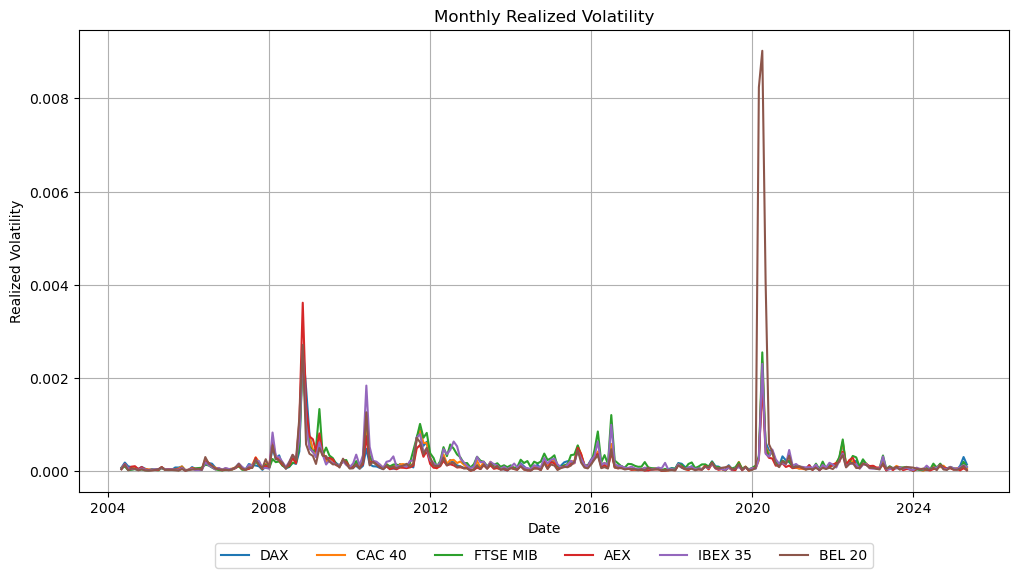

In [45]:
# We need to exclude Greece here otherwise plot is unreadable
columns = columns[columns != "FTSE Athens20"]
plt.figure(figsize=(12, 6))
plt.plot(RV.index, RV[columns], label=columns)
plt.title("Monthly Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.18), ncol=6)
plt.grid()
plt.show()

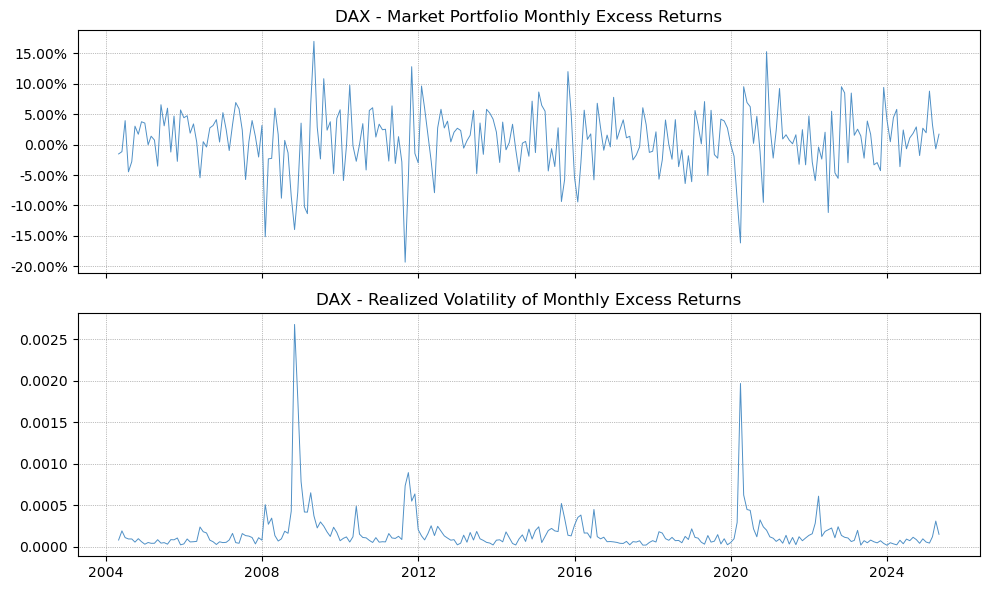

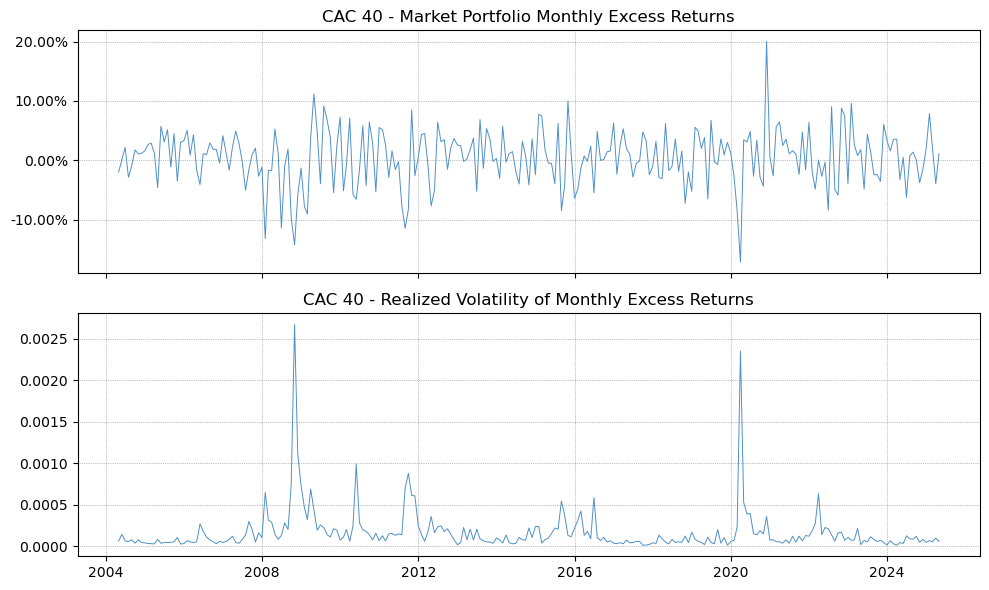

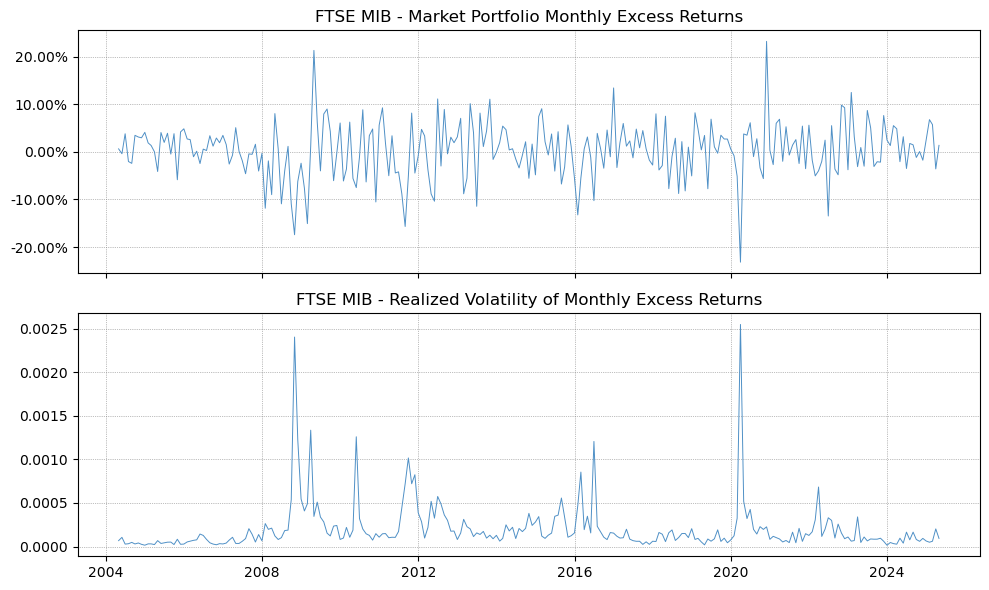

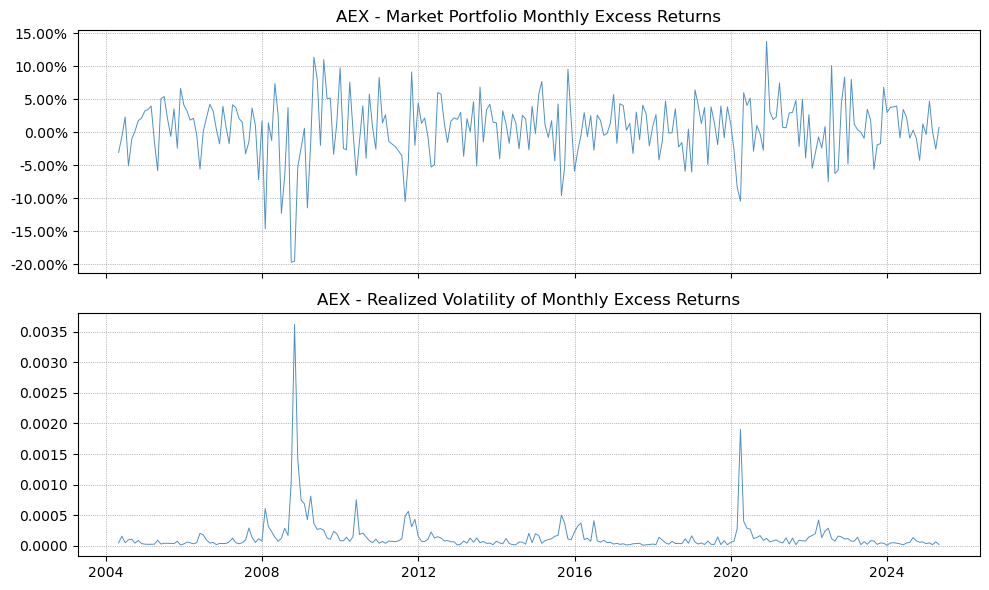

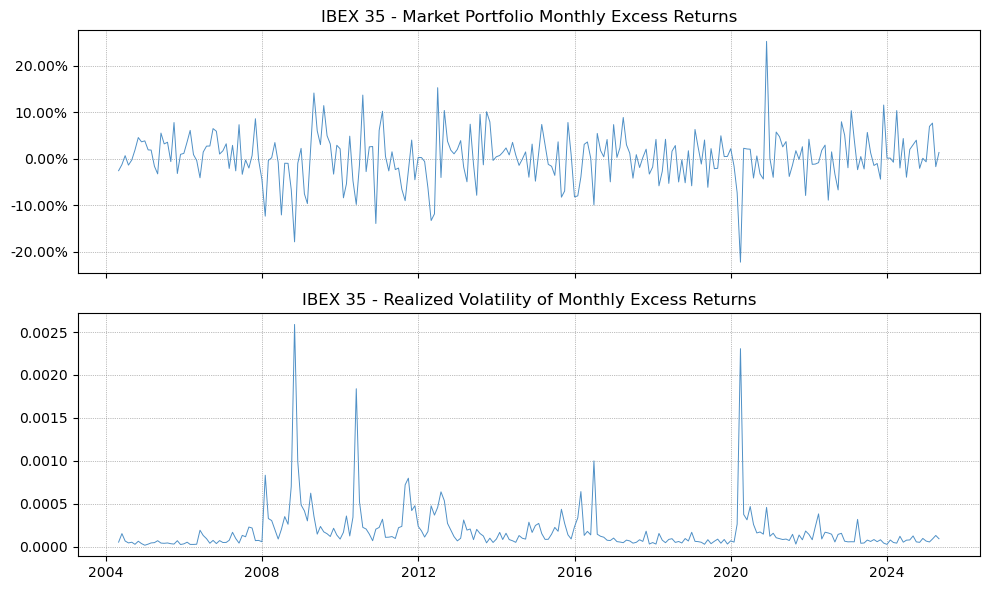

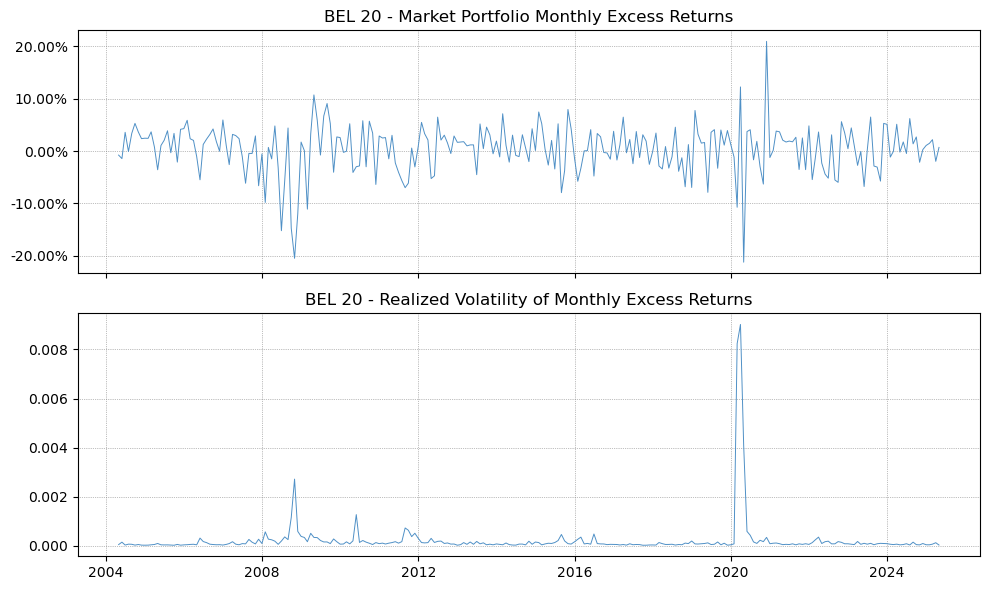

In [46]:
# Plotting the monthly returns and realized volatility for each index
for col in columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Monthly Returns
    axes[0].plot(monthlty_Returns_Index_Futures.index, monthlty_Returns_Index_Futures[col], color="#4f90c6", linewidth=0.7)
    axes[0].set_title(f"{col} - Market Portfolio Monthly Excess Returns")
    axes[0].grid(True, linestyle=":", linewidth=0.5, color='grey')
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.2f}%'))

    # Realized Volatility or other data from RV
    axes[1].plot(RV.index, RV[col], color="#4f90c6", linewidth=0.7)
    axes[1].set_title(f"{col} - Realized Volatility of Monthly Excess Returns")
    axes[1].grid(True, linestyle=":", linewidth=0.5, color='grey')

    plt.tight_layout()
    plt.show()

<div class="alert alert-info">

Self Note: Add recession periods.

</div>

Following paper by Van Hemert et al. (2018) we have plotted the daily, monthly and annual excess returns
and the wealth index. 

**Why?** The plot has been added to check wether returns are clustered. (Similar to Exibit 3)

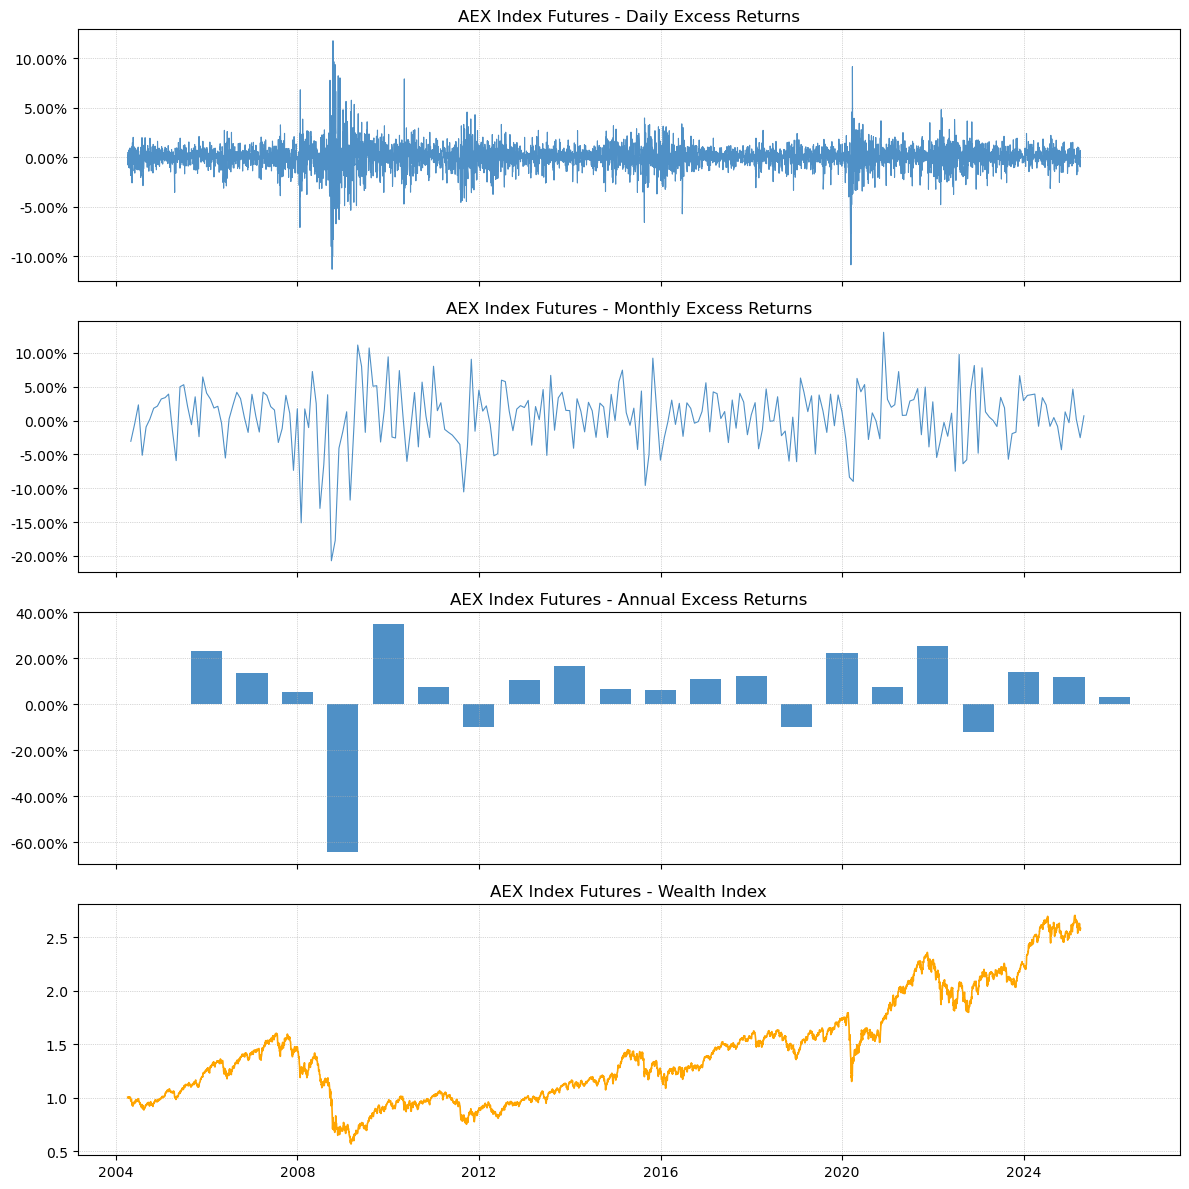

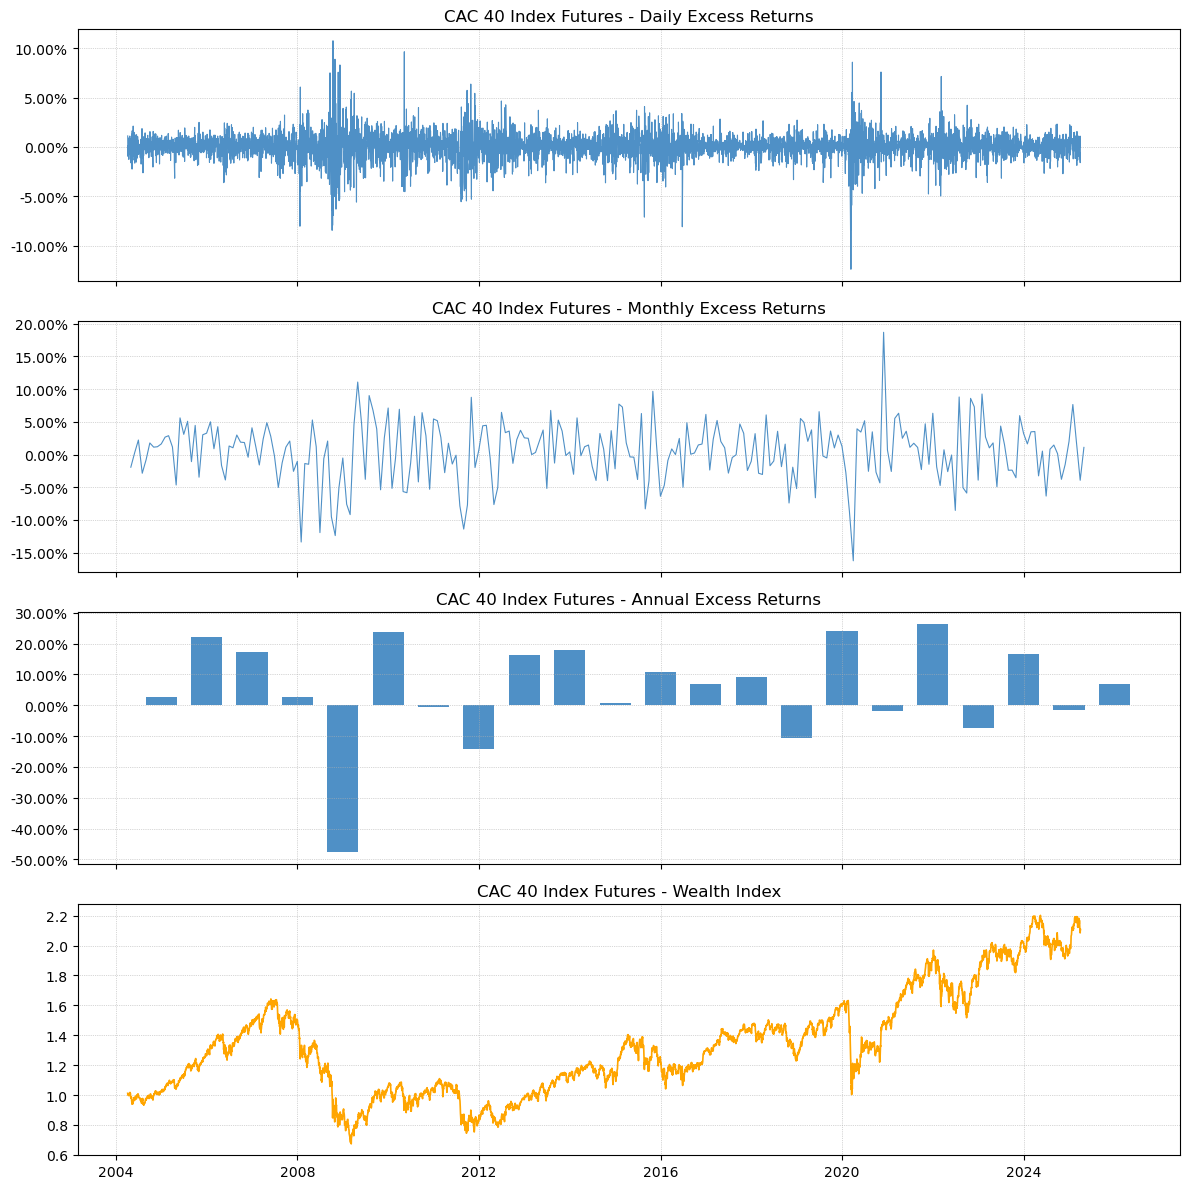

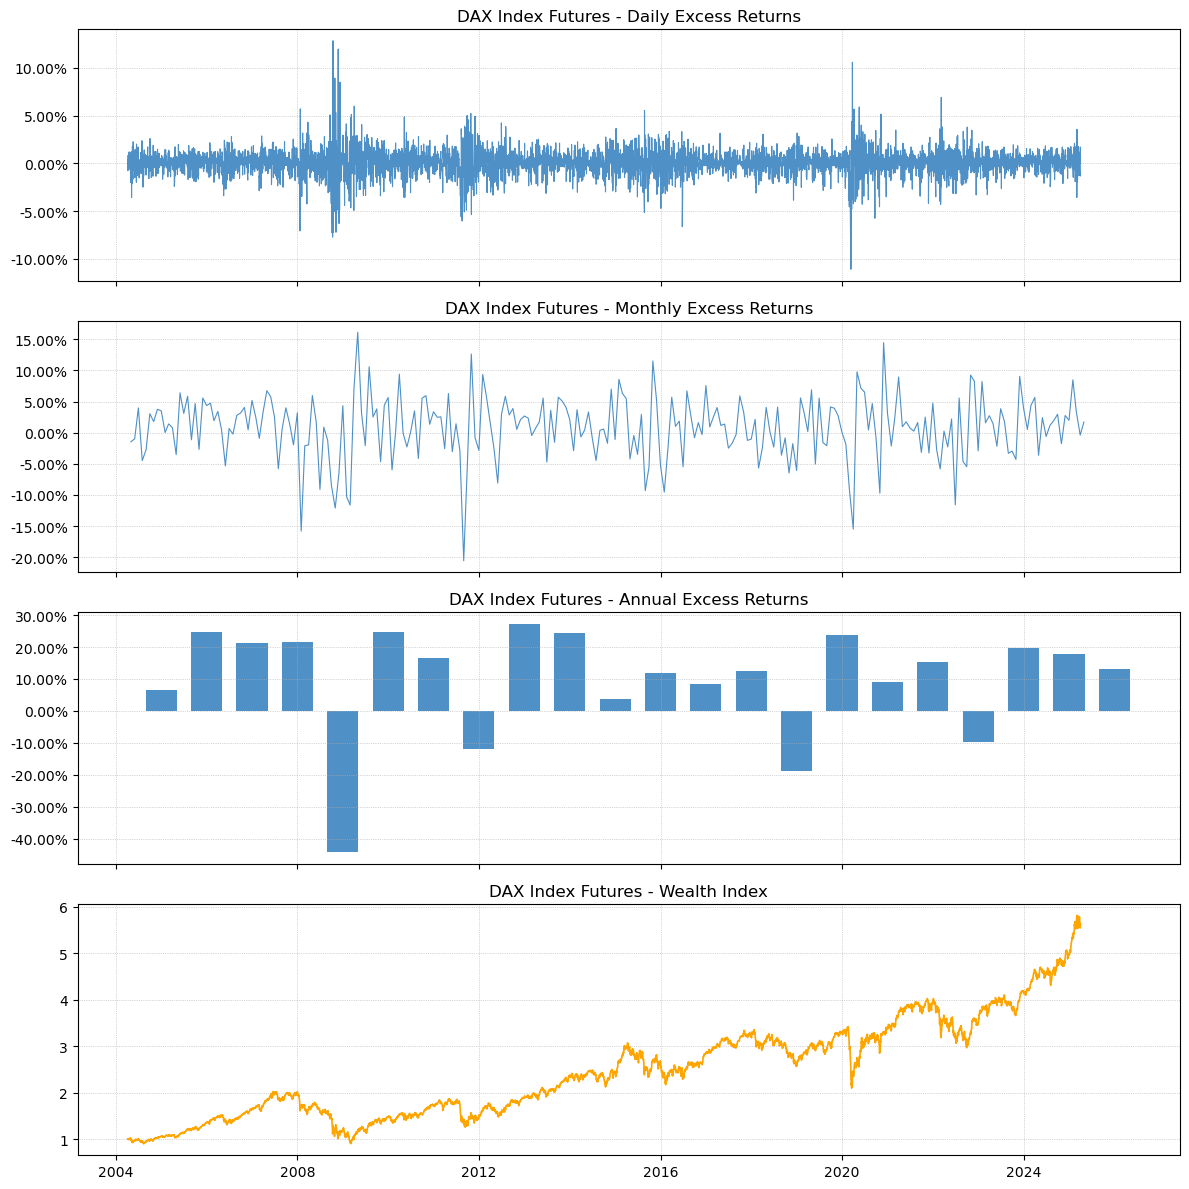

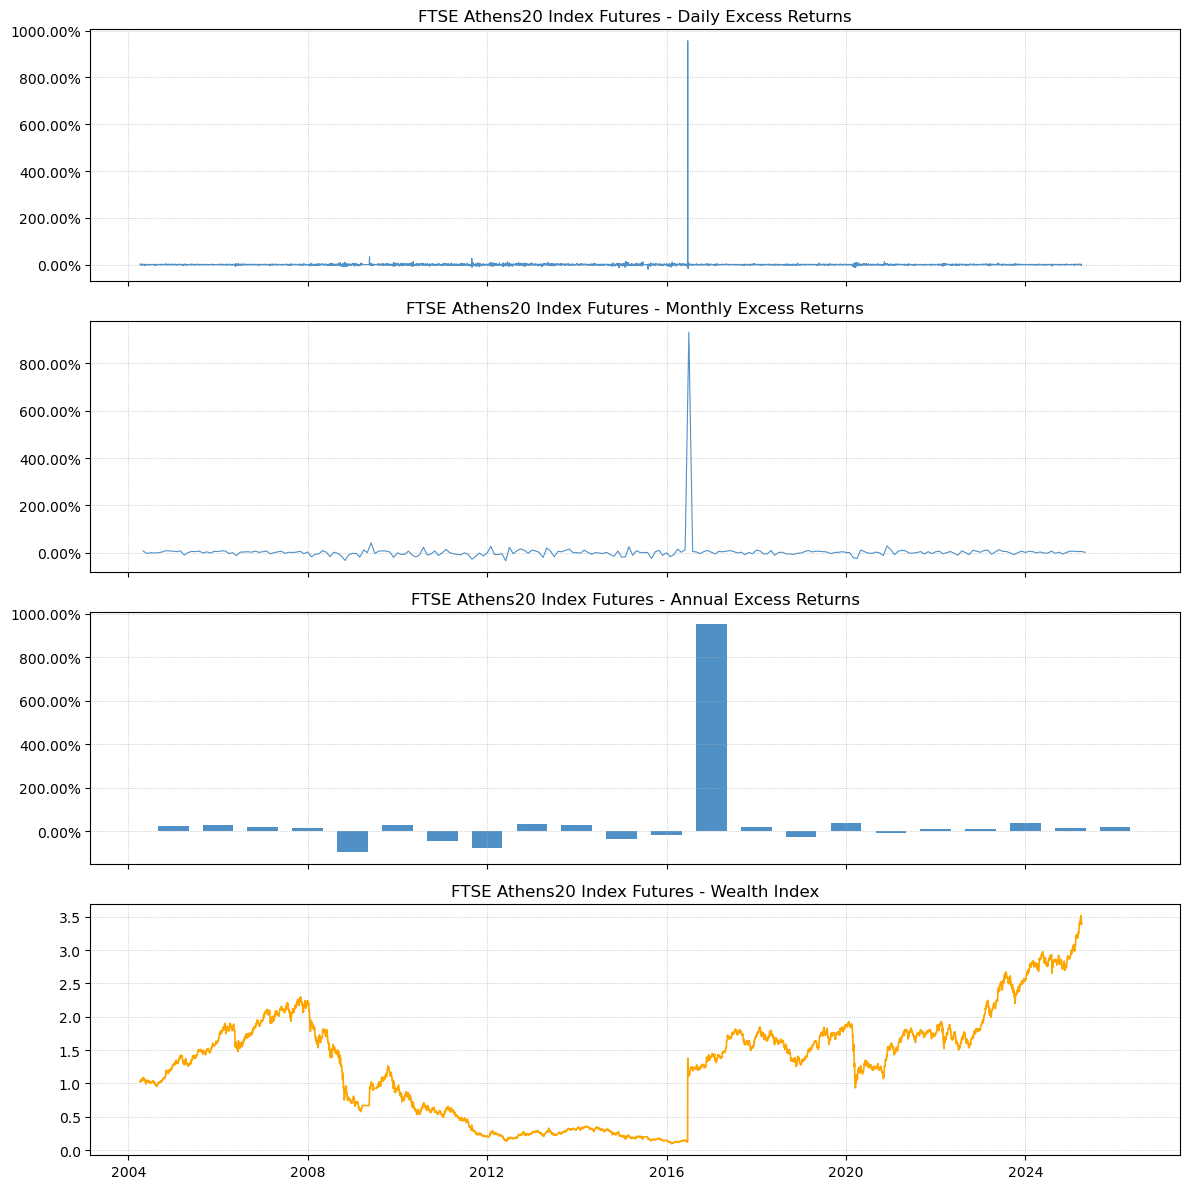

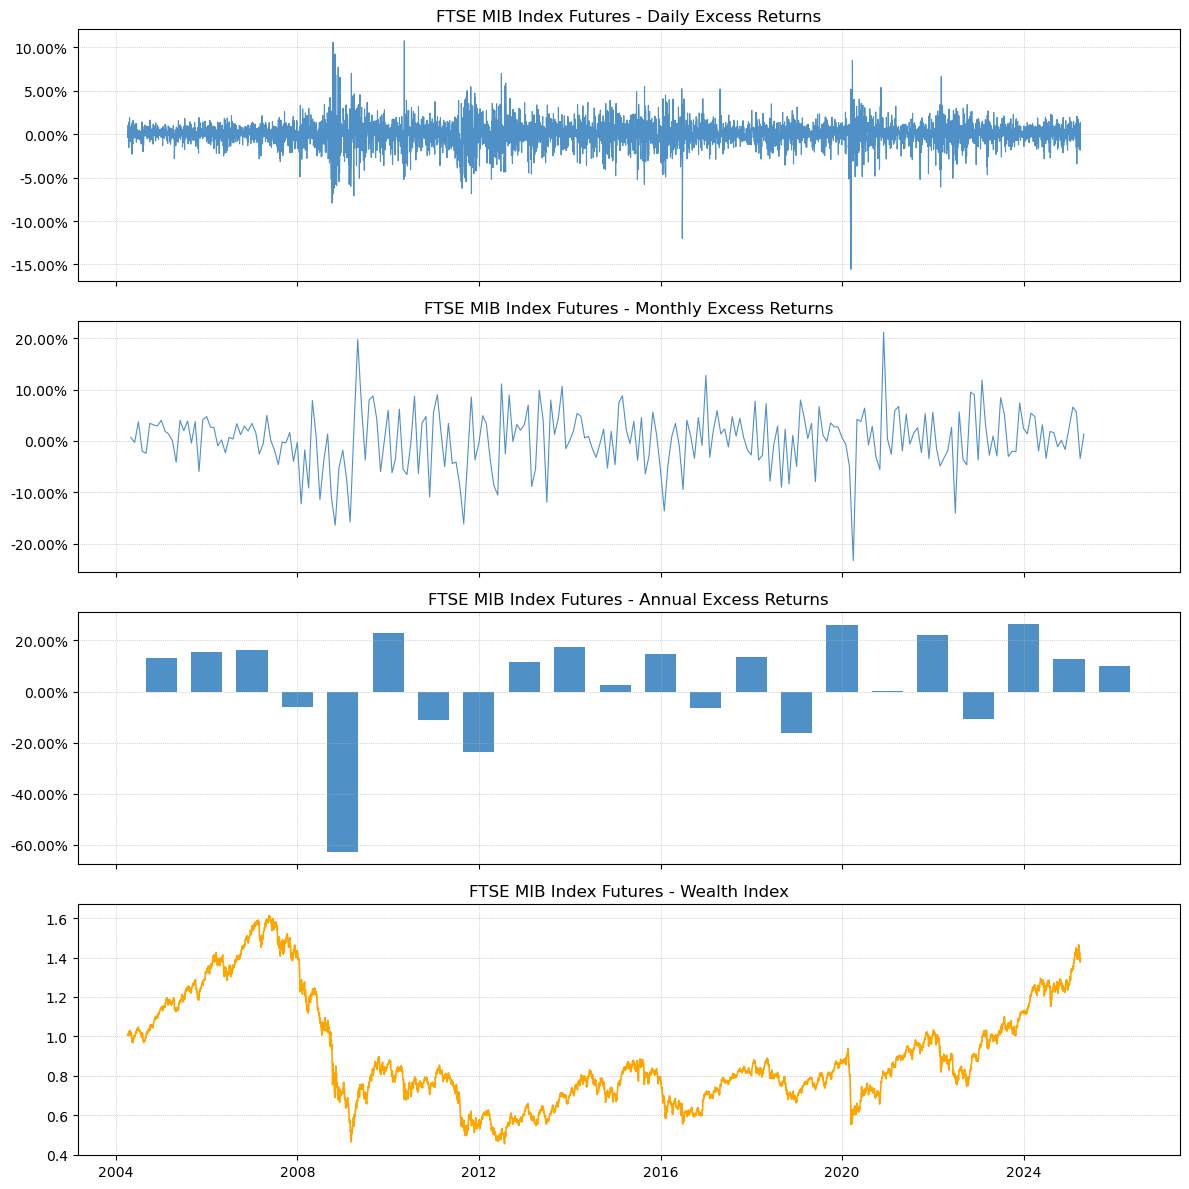

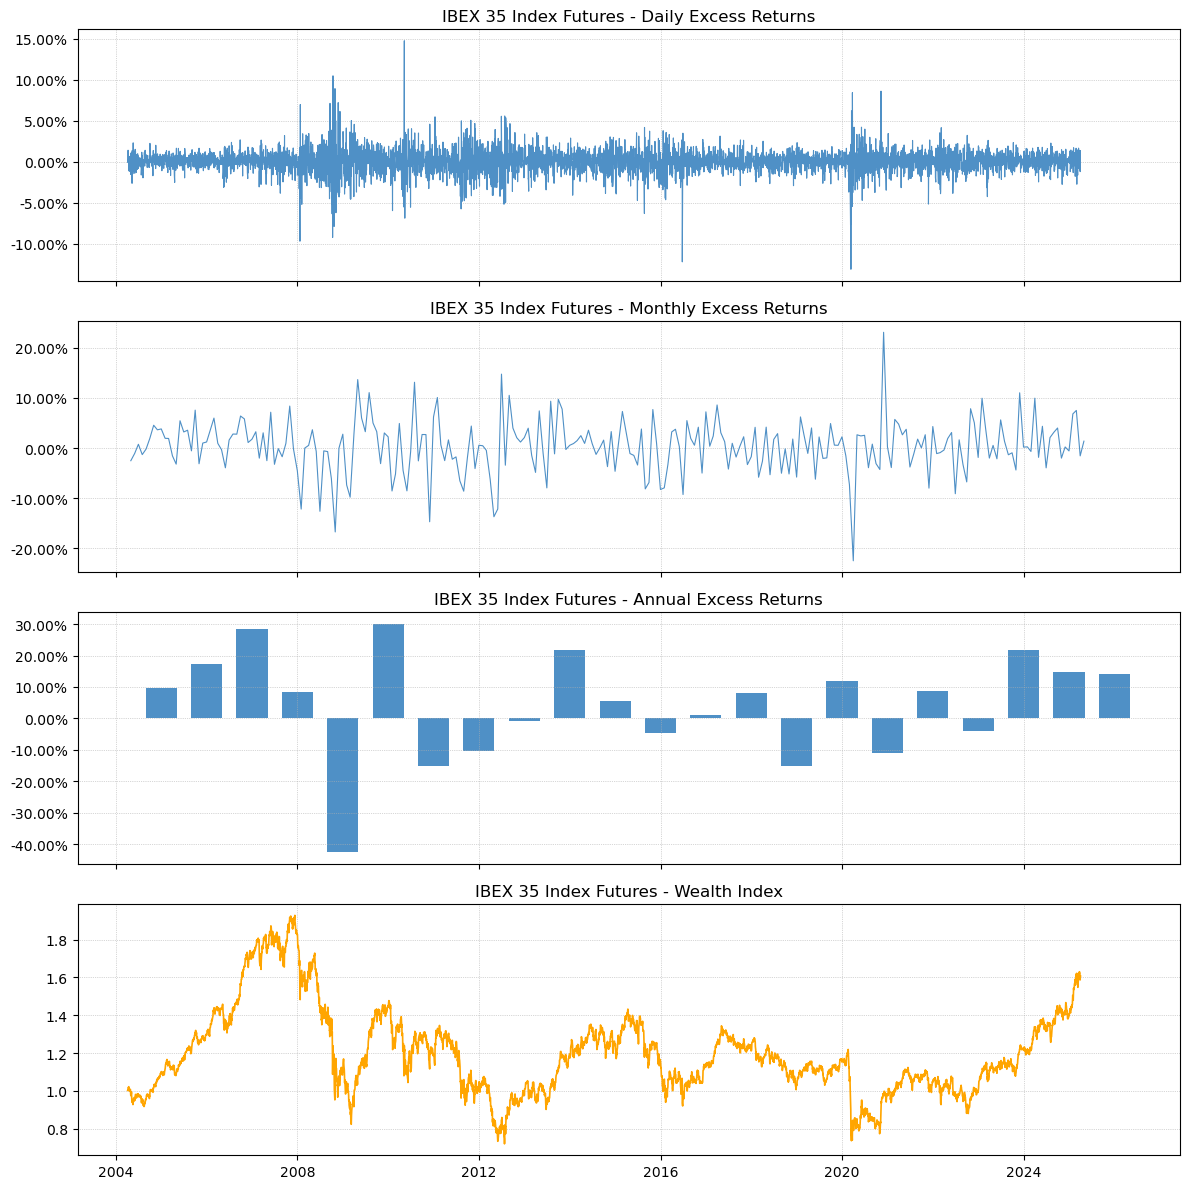

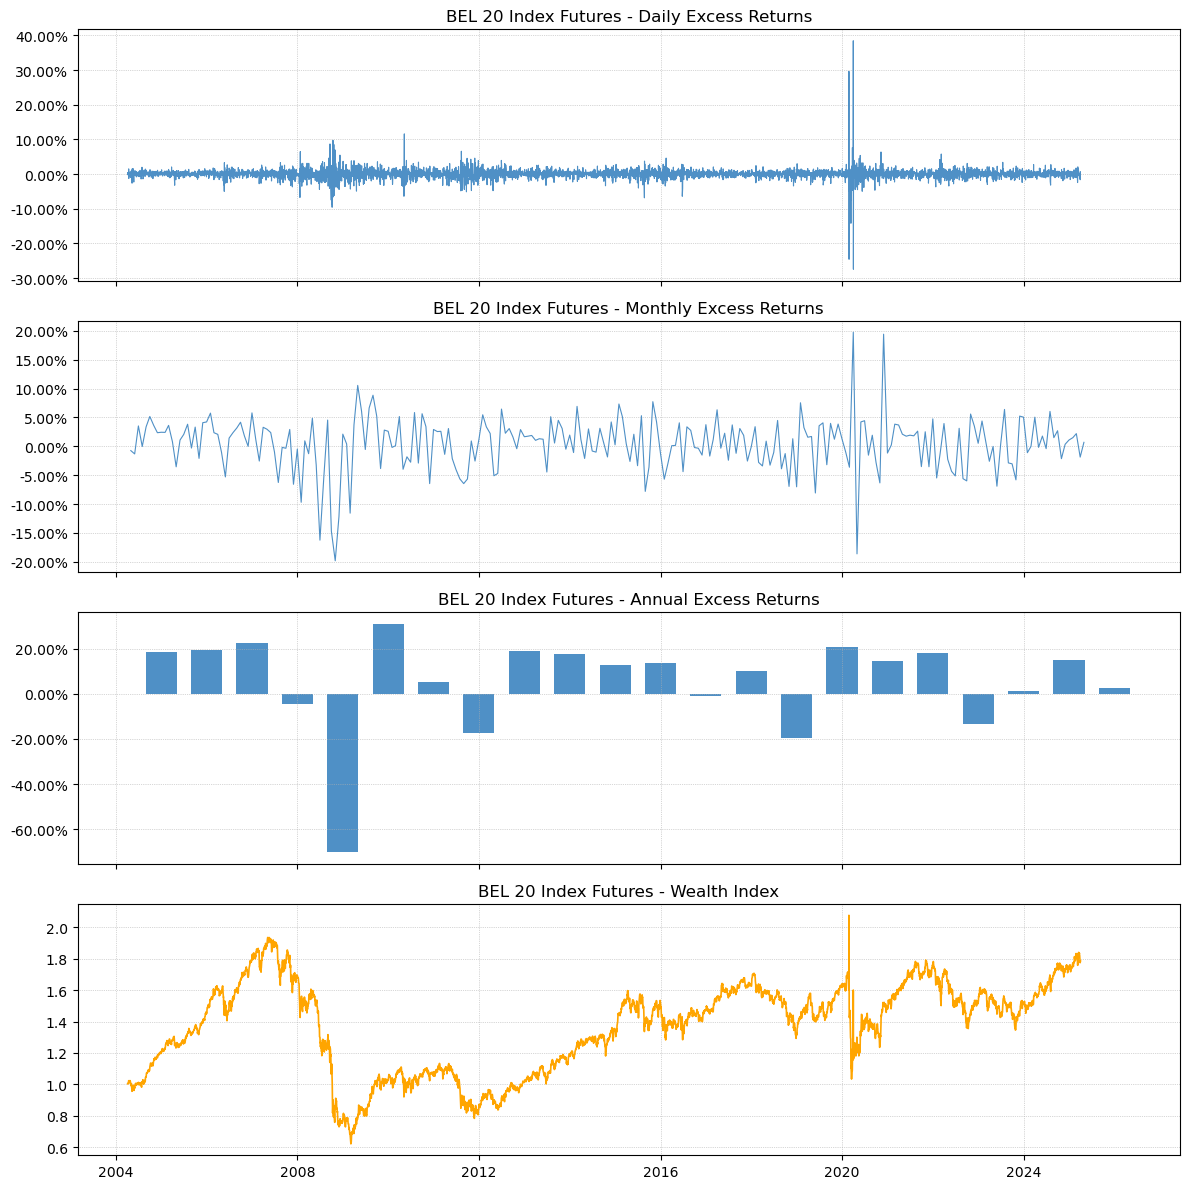

In [47]:
plot_excess_returns(daily_Returns_Index_Futures['AEX'], "AEX Index Futures")
plot_excess_returns(daily_Returns_Index_Futures['CAC 40'], "CAC 40 Index Futures")
plot_excess_returns(daily_Returns_Index_Futures['DAX'], "DAX Index Futures")
plot_excess_returns(daily_Returns_Index_Futures['FTSE Athens20'], "FTSE Athens20 Index Futures")
plot_excess_returns(daily_Returns_Index_Futures['FTSE MIB'], "FTSE MIB Index Futures")
plot_excess_returns(daily_Returns_Index_Futures['IBEX 35'], "IBEX 35 Index Futures")
plot_excess_returns(daily_Returns_Index_Futures['BEL 20'], "BEL 20 Index Futures")

**Quantile Analysis** used in Exibit 4  Van Hemert et al. (2018) and Figure 1 Moeira and Muir (2017) 
Follwing the methodology from Moeira and Muir (2017) we need to calculate market potfolio returns.

**Why?** The visulaizations aim is to show whether there are any persistent relationship between lagged volatoility and returns/volatility/mean-variance trade-offs. 

DAX 30


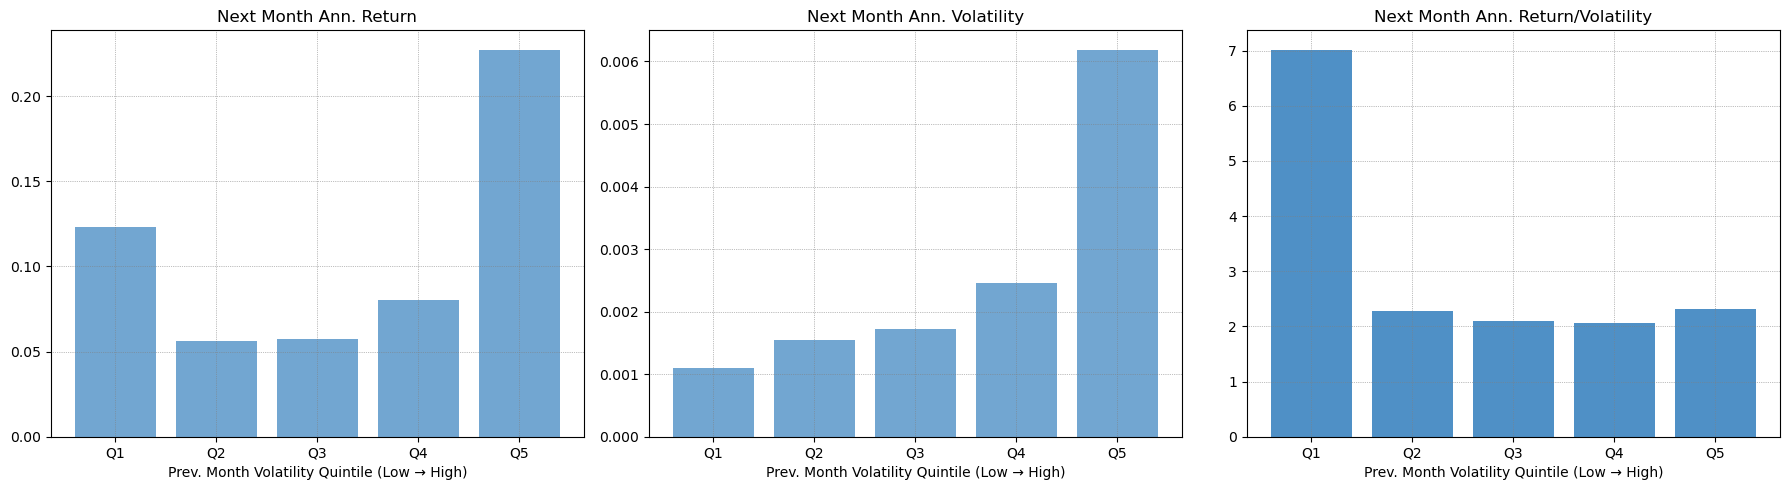

CAC 40


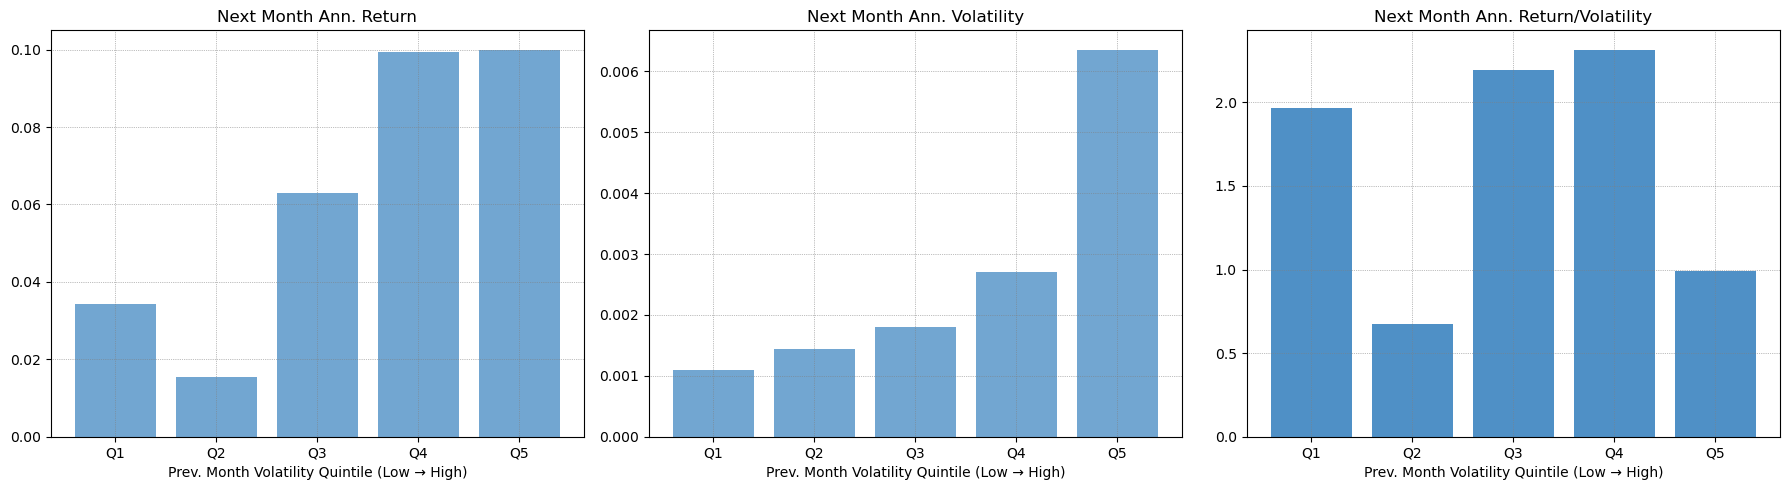

FTSE Athens20


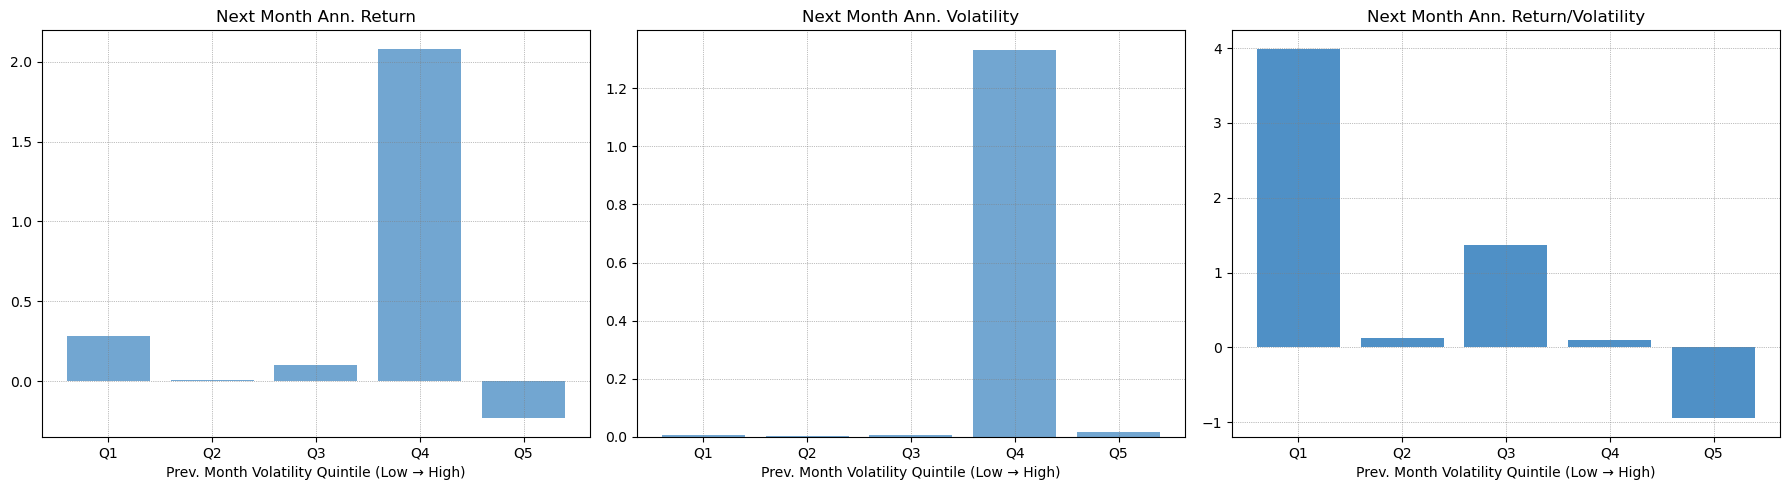

FTSE MIB


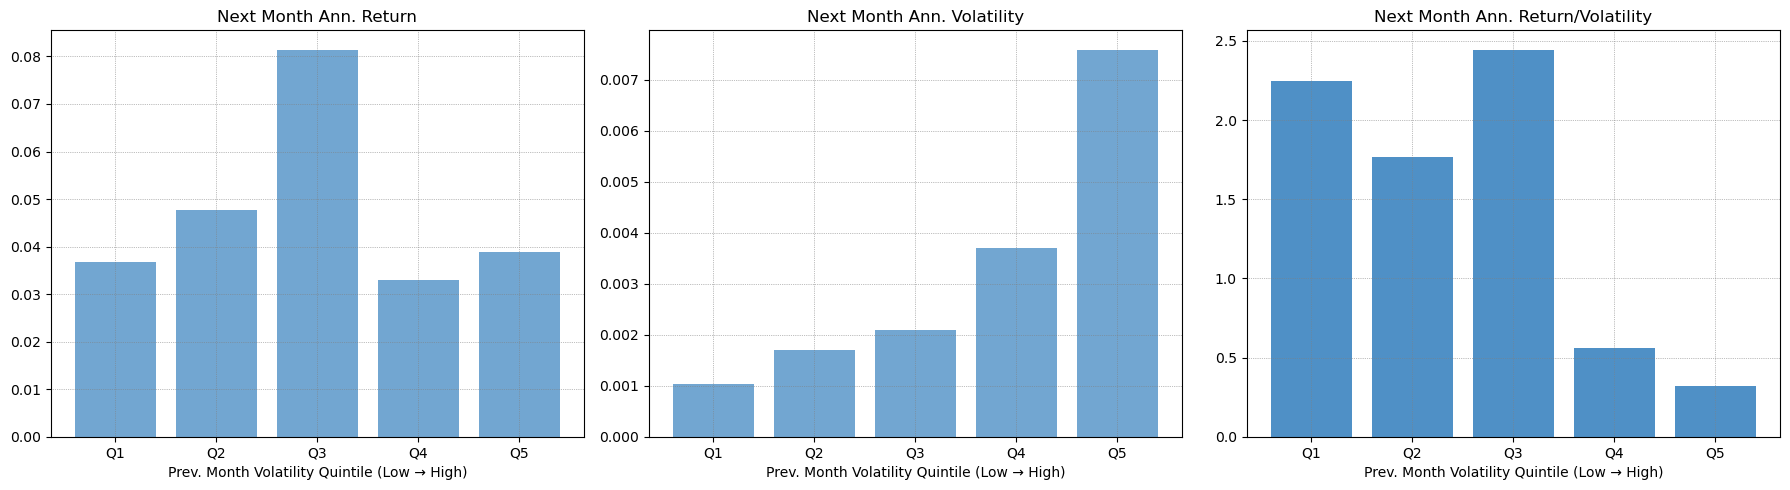

AEX


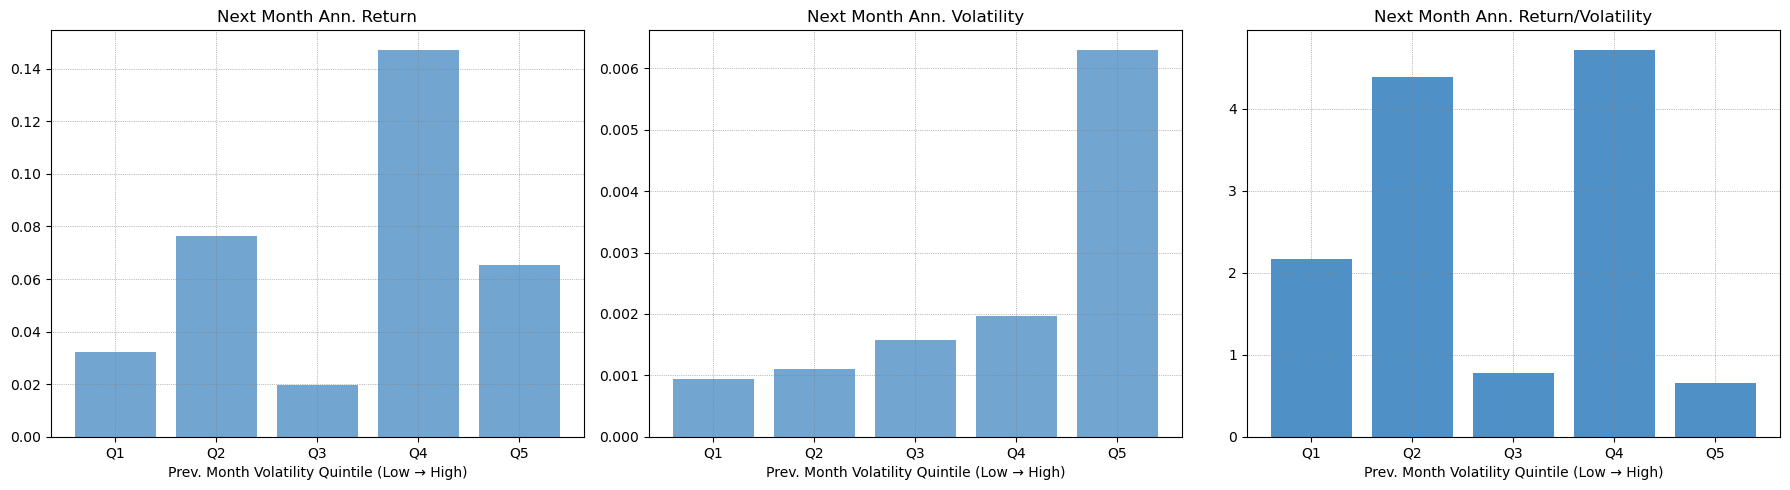

IBEX 35


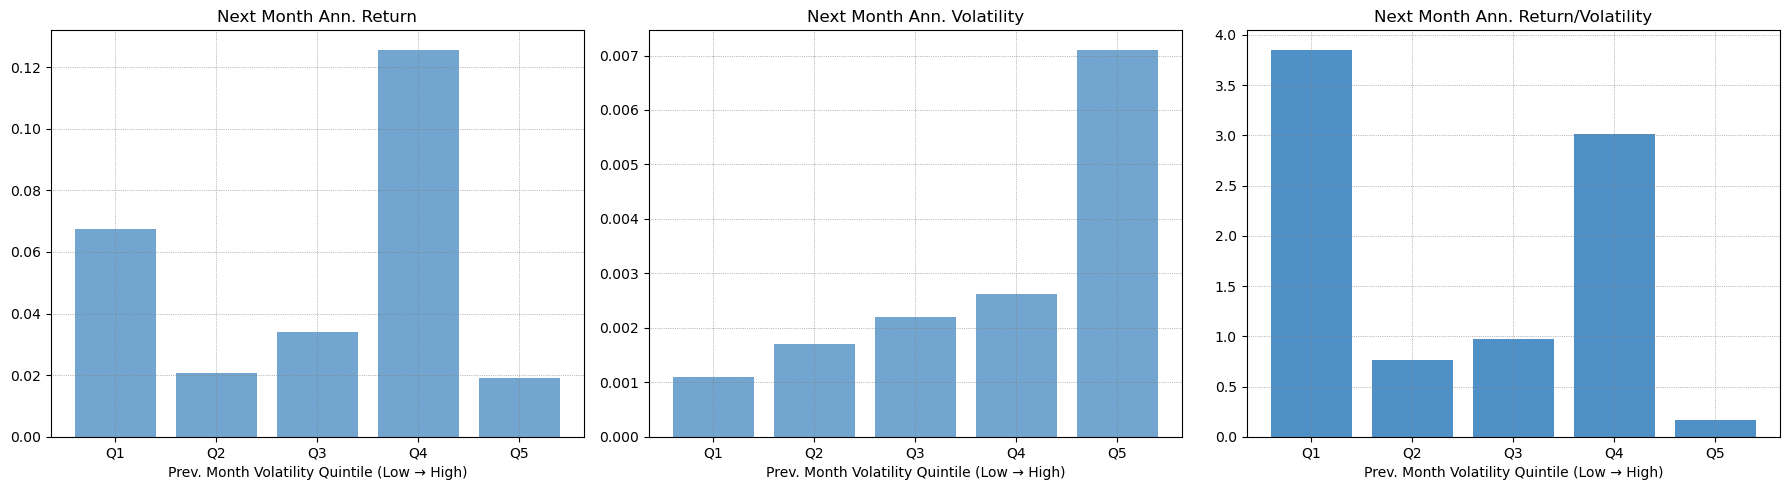

BEL 20


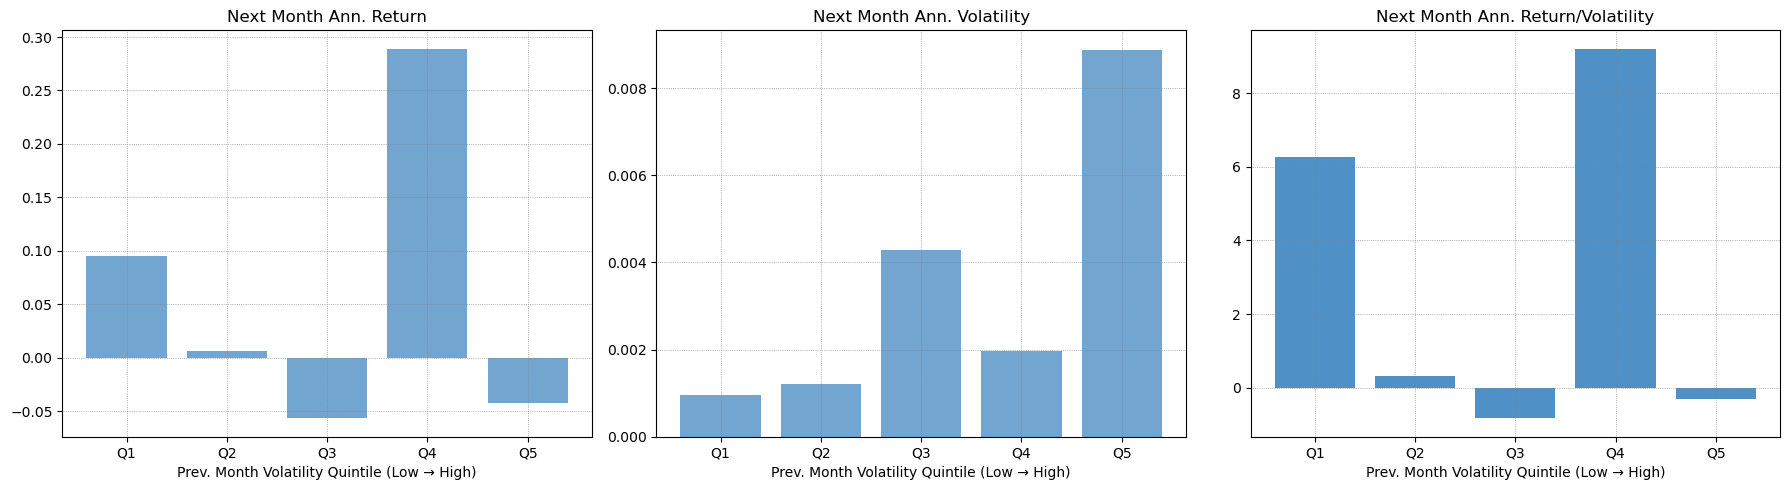

In [48]:
# Volatility (both annualized)when sorting on the previous month’s volatility

print("DAX 30")
# DAX 30: 
dax_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='DAX'
)
dax_result
visualize_quantile_analysis(dax_result)

print("CAC 40")
# CAC 40:
cac_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='CAC 40'
)
cac_result
visualize_quantile_analysis(cac_result)

print("FTSE Athens20")
# FTSE Athens20:
athens_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='FTSE Athens20'
)
athens_result
visualize_quantile_analysis(athens_result)

print("FTSE MIB")
# FTSE MIB:
mib_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='FTSE MIB'
)
mib_result
visualize_quantile_analysis(mib_result)

print("AEX")
# AEX:
aex_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='AEX'
)
aex_result
visualize_quantile_analysis(aex_result)

print("IBEX 35")
# IBEX 35:
ibex_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='IBEX 35'
)
ibex_result 
visualize_quantile_analysis(ibex_result)

print("BEL 20")
# BEL 20:
bel_result = analyze_by_prev_month_volatility(
    daily_returns_df=daily_Returns_Index_Futures,
    endofmonth=endofmonth,
    column='BEL 20'
)
bel_result
visualize_quantile_analysis(bel_result)

# Market Portfolio - Indices

In [49]:
# Calculate the market portfolio weights using the using optimzation

market_returns_df = []
dates = []
weights = []
lookback = 60 # 5 years lookback

for i in range(len(monthlty_Returns_Index_Futures) - lookback - 1): 
    past_returns = monthlty_Returns_Index_Futures.iloc[i : lookback + i]  
    next_day_returns = monthlty_Returns_Index_Futures.iloc[lookback + i]  
    weights = mvp_portfolio_unconstrained(past_returns)  # Use the new function for weights calculation
    market_return = np.dot(weights, next_day_returns)  

    market_returns_df.append(market_return)
    dates.append(monthlty_Returns_Index_Futures.index[lookback + i])  # Save date for tracking

market_returns_df = pd.DataFrame({'Date': dates, 'Market_Return': market_returns_df}).set_index('Date')


In [50]:
# Unreasonable Results 
market_returns_df['Market_Return'].describe().round(4)

count     192.0000
mean       31.3756
std       491.7490
min     -3578.7825
25%        -0.0671
50%         0.0122
75%         0.1360
max      3071.3031
Name: Market_Return, dtype: float64

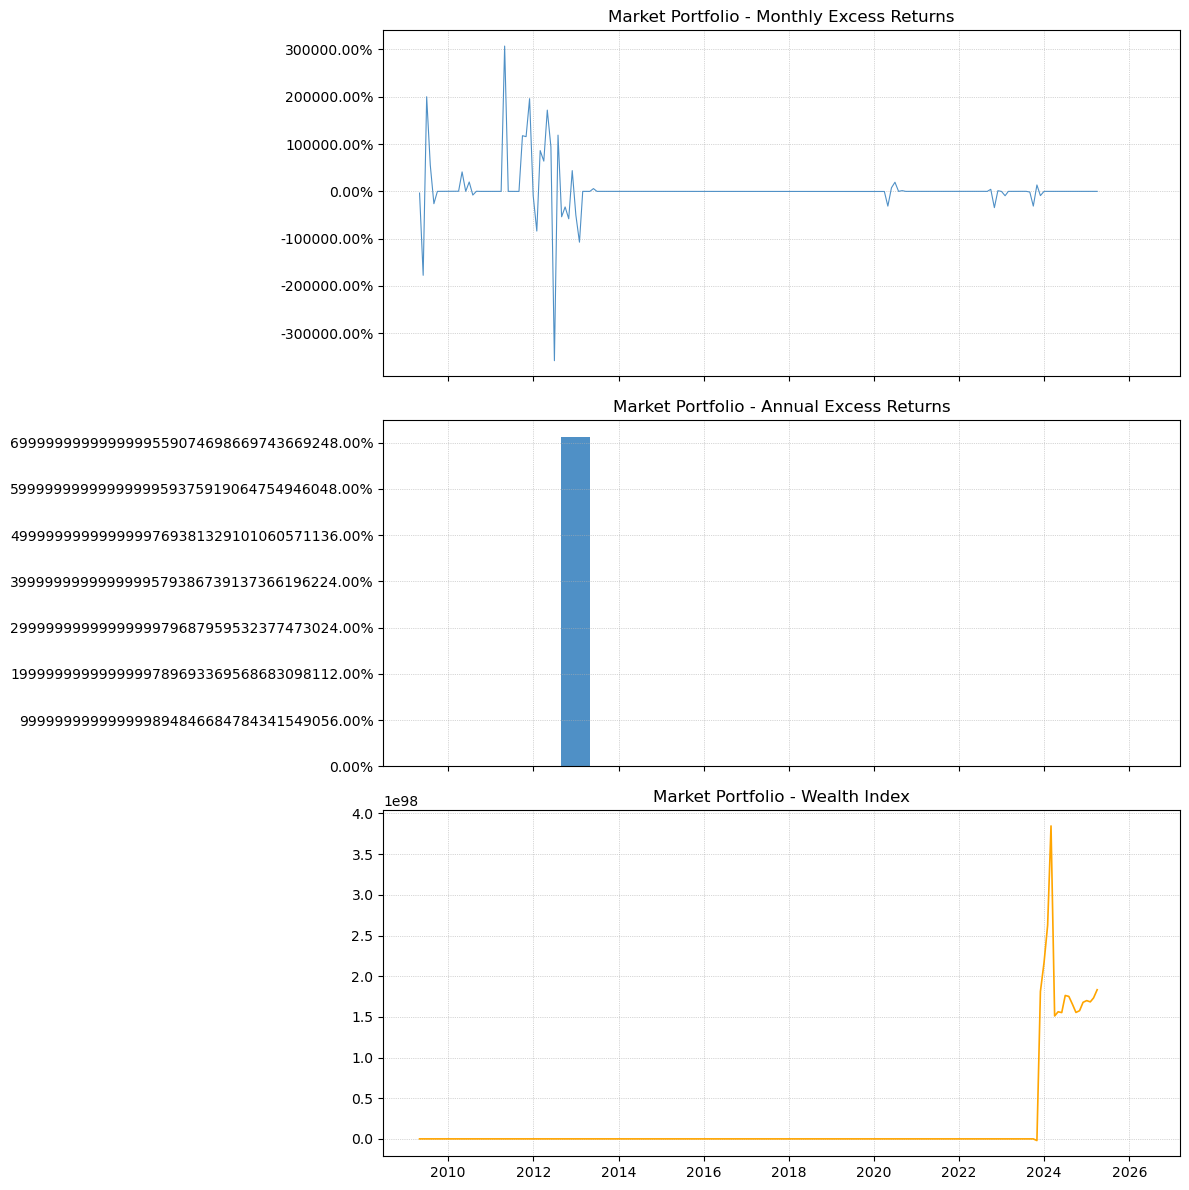

In [51]:
plot_market_portfolio(market_returns_df)

In [52]:
# Lets try without Greece
# Calculate the market portfolio weights using the using optimzatio

market_returns_df = []
dates = []
weights = []
lookback = 60 # 5 years lookback
columns =['DAX', 'CAC 40', 'FTSE MIB', 'AEX', 'IBEX 35',
       'BEL 20']

for i in range(len(monthlty_Returns_Index_Futures) - lookback - 1): 
    past_returns = monthlty_Returns_Index_Futures[columns].iloc[i : lookback + i]  
    next_day_returns = monthlty_Returns_Index_Futures[columns].iloc[lookback + i]  
    weights = mvp_portfolio_unconstrained(past_returns)  # Use the new function for weights calculation
    market_return = np.dot(weights, next_day_returns)  

    market_returns_df.append(market_return)
    dates.append(monthlty_Returns_Index_Futures[columns].index[lookback + i])  # Save date for tracking

market_returns_df = pd.DataFrame({'Date': dates, 'Market_Return': market_returns_df}).set_index('Date')

In [53]:
# Not better
market_returns_df['Market_Return'].describe().round(4)

count     192.0000
mean       24.1031
std       283.9572
min     -2200.2933
25%        -0.0602
50%         0.0201
75%         0.1304
max      1676.7308
Name: Market_Return, dtype: float64

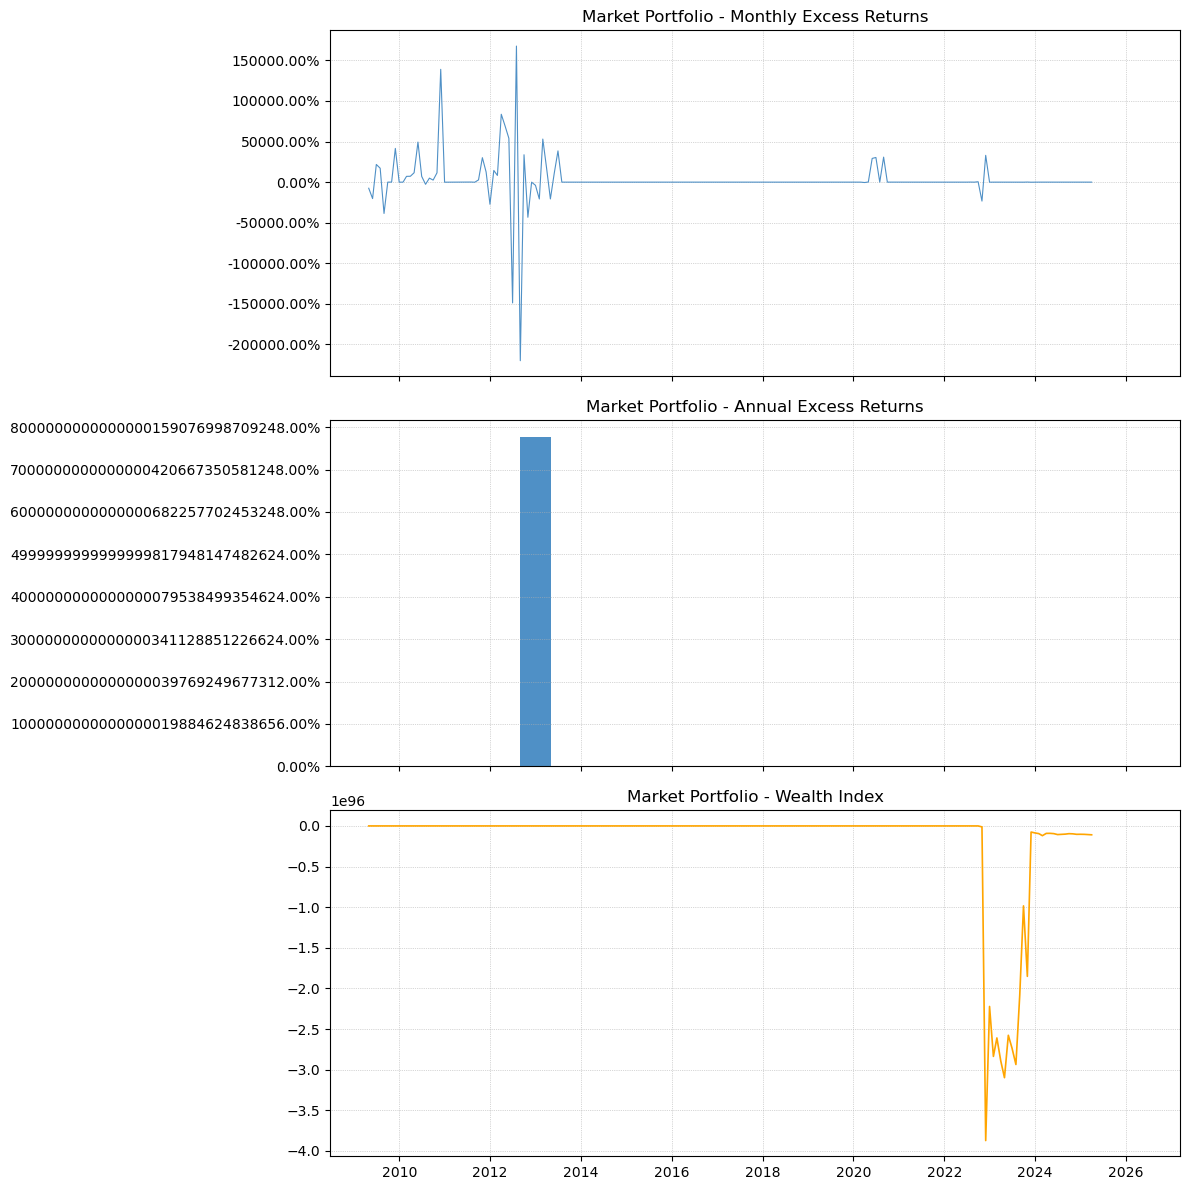

In [54]:
plot_market_portfolio(market_returns_df)

In [55]:
# Maybe closed form solution is better??

market_returns_df = []
dates = []
weights = []
lookback = 60 # 5 years lookback

for i in range(len(monthlty_Returns_Index_Futures) - lookback - 1): 
    past_returns = monthlty_Returns_Index_Futures.iloc[i : lookback + i]  
    next_day_returns = monthlty_Returns_Index_Futures.iloc[lookback + i]  
    weights = market_portfolio_weights_closed_form(past_returns)  # Use the new function for weights calculation
    market_return = np.dot(weights, next_day_returns)  

    market_returns_df.append(market_return)
    dates.append(monthlty_Returns_Index_Futures.index[lookback + i])  # Save date for tracking

market_returns_df = pd.DataFrame({'Date': dates, 'Market_Return': market_returns_df}).set_index('Date')

In [56]:
# Looks promising
market_returns_df['Market_Return'].describe().round(4) 

count    192.0000
mean      -0.2737
std        5.9495
min      -78.6287
25%       -0.0557
50%        0.0132
75%        0.1390
max        8.0471
Name: Market_Return, dtype: float64

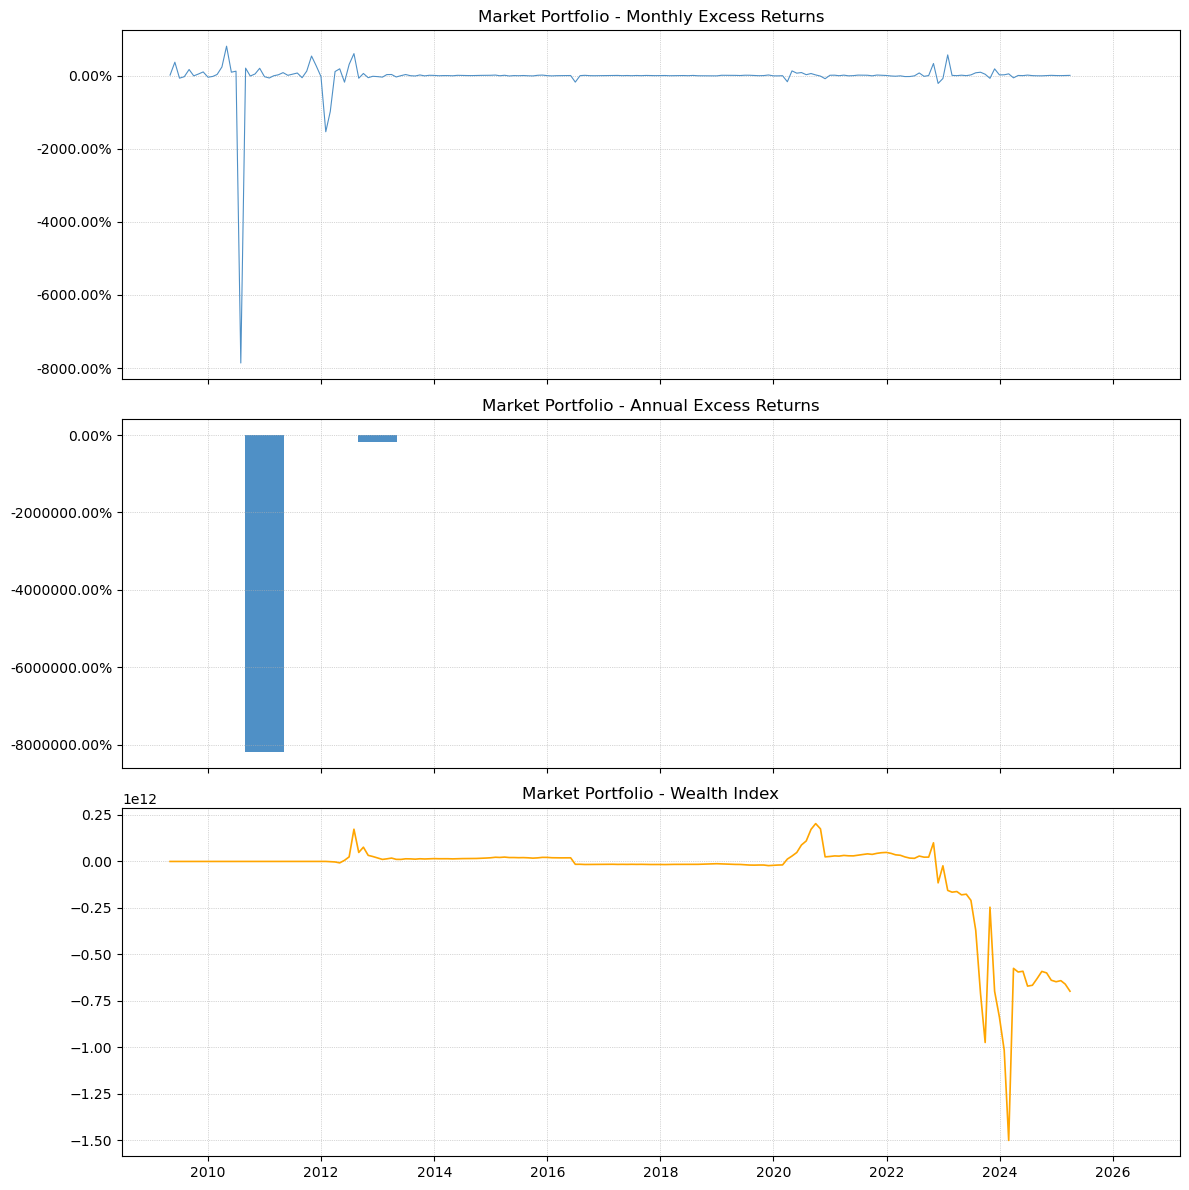

In [57]:
# Bad
plot_market_portfolio(market_returns_df)

In [58]:
# Againg, no Greece
market_returns_df = []
dates = []
weights = []
lookback = 60 # 5 years lookback
columns =['DAX', 'CAC 40', 'FTSE MIB', 'AEX', 'IBEX 35',
       'BEL 20']

for i in range(len(monthlty_Returns_Index_Futures) - lookback - 1): 
    past_returns = monthlty_Returns_Index_Futures[columns].iloc[i : lookback + i]  
    next_day_returns = monthlty_Returns_Index_Futures[columns].iloc[lookback + i]  
    weights = market_portfolio_weights_closed_form(past_returns)  # Use the new function for weights calculation
    market_return = np.dot(weights, next_day_returns)  

    market_returns_df.append(market_return)
    dates.append(monthlty_Returns_Index_Futures[columns].index[lookback + i])  # Save date for tracking

market_returns_df = pd.DataFrame({'Date': dates, 'Market_Return': market_returns_df}).set_index('Date')

In [59]:
market_returns_df['Market_Return'].describe().round(4)

count    192.0000
mean       3.3381
std       42.9335
min       -7.5938
25%       -0.0615
50%        0.0163
75%        0.1012
max      594.5404
Name: Market_Return, dtype: float64

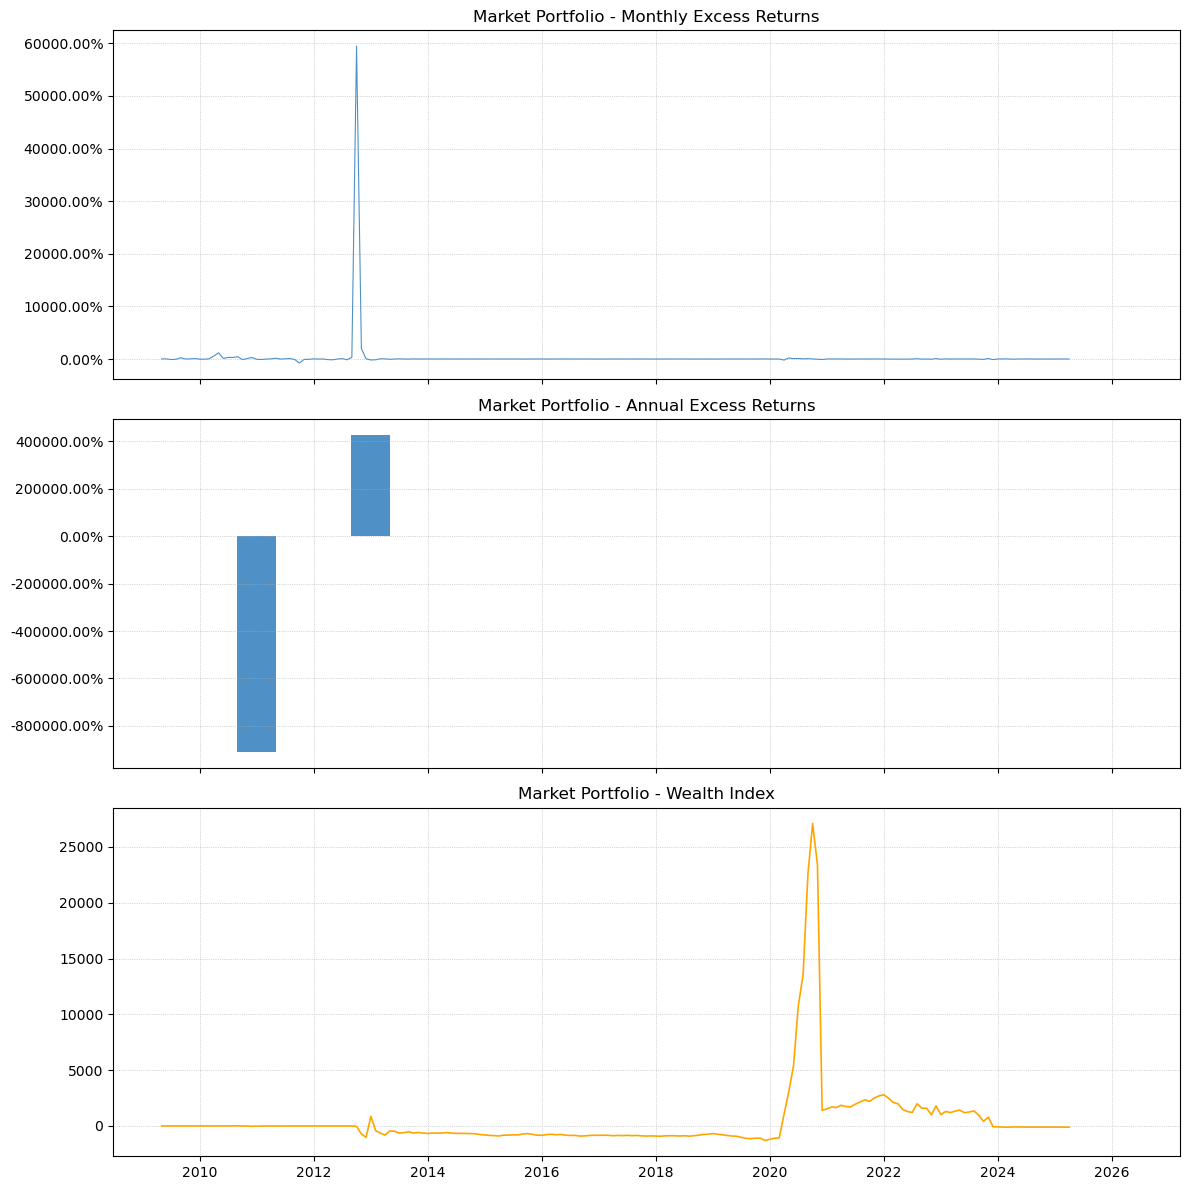

In [60]:
# Still bad
plot_market_portfolio(market_returns_df)

# Analsis of Metals

In [ ]:
# Daily Settlement Price of Futures, data obtained from Bloomberg
daily_Price_Metals_Futures = pd.read_excel("./Futures Prices.xlsx", sheet_name="INDEX PX_SETTLE").set_index("DATE")
daily_Price_Metals_Futures.head(3)